In [1]:
# Obucavanje se vrsi baseline-u dok se testiranje vrsi na ostalim segmentima
# Testirani modeli su: RF, SVM, GNB, LDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from scipy import stats

In [3]:
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, make_scorer

In [5]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, cohen_kappa_score, accuracy_score

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import pickle

In [8]:
%matplotlib inline

In [9]:
dat_12_samples = pd.read_csv('/Features.csv',sep=',')
dat_8_samples = pd.read_csv('/Features_without_neutral.csv',sep=',')

In [10]:
dat_baseline = pd.DataFrame([],columns=dat_12_samples.columns)
dat_anger = pd.DataFrame([],columns=dat_12_samples.columns)
dat_neutral = pd.DataFrame([],columns=dat_12_samples.columns)

In [11]:
dat = pd.concat([dat_12_samples,dat_8_samples])

In [12]:
for i in range(len(dat)):
    temp = dat.iloc[i,0]
    if temp[-1] == '1':
        dat_baseline = dat_baseline.append(dat.iloc[i],ignore_index=True)
    elif temp[-1] == '2':
        dat_anger = dat_anger.append(dat.iloc[i],ignore_index=True)
    elif temp[-1] == '3':
        dat_neutral = dat_neutral.append(dat.iloc[i],ignore_index=True)

In [13]:
for i in range(len(dat_baseline)):
    temp = dat_baseline.iloc[i,0]
    dat_baseline.iloc[i,0] = temp[:-4]

for i in range(len(dat_anger)):
    temp = dat_anger.iloc[i,0]
    dat_anger.iloc[i,0] = temp[:-4]

for i in range(len(dat_neutral)):
    temp = dat_neutral.iloc[i,0]
    dat_neutral.iloc[i,0] = temp[:-4]

In [14]:
skf = StratifiedKFold(n_splits=4, shuffle=True) 

In [15]:
scaler = StandardScaler()

In [16]:
with open('best_params_all.pkl', 'rb') as f:
    best_params_all = pickle.load(f)

In [17]:
le = LabelEncoder()
    
dat_baseline['examinee'] = le.fit_transform(dat_baseline['examinee'])
dat_anger['examinee'] = le.transform(dat_anger['examinee'])
dat_neutral['examinee'] = le.transform(dat_neutral['examinee'])

In [18]:
X_neutral = dat_neutral.drop('examinee',axis=1)
y_neutral = dat_neutral['examinee']

In [19]:
X_anger = dat_anger.drop('examinee',axis=1)
y_anger = dat_anger['examinee']

In [20]:
X_train = dat_baseline.drop('examinee',axis=1)
y_train = dat_baseline['examinee']

In [21]:
X_train_scaled = scaler.fit_transform(X_train)
X_anger_scaled = scaler.transform(X_anger)
X_neutral_scaled = scaler.transform(X_neutral)

In [22]:
X = X_train
y = y_train

In [23]:
num_runs = 20

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
np.arange(0,4)[:3]

array([0, 1, 2])

In [26]:
rforest_scores = np.zeros((3,1))
rforest_precision_recall_fscore = np.zeros((3,3))
# for i in range(num_runs):
rforest = RandomForestClassifier(**best_params_all['RF'])
rforest_scores[0] = np.mean(cross_val_score(rforest, X_train, y_train, cv = skf))
rforest_precision_recall_fscore[0,0] = np.mean(cross_val_score(rforest, X_train, y_train, cv=skf, scoring='precision_weighted'))
rforest_precision_recall_fscore[0,1] = np.mean(cross_val_score(rforest, X_train, y_train, cv=skf, scoring='recall_weighted'))
rforest_precision_recall_fscore[0,2] = np.mean(cross_val_score(rforest, X_train, y_train, cv=skf, scoring='f1_weighted'))
rforest.fit(X_train,y_train)
y_hat = rforest.predict(X_anger)
rforest_scores[1] = accuracy_score(y_anger, y_hat)
rforest_precision_recall_fscore[1,:] = precision_recall_fscore_support(y_anger,y_hat,average='weighted')[:3]
y_hat = rforest.predict(X_neutral)
rforest_scores[2] = accuracy_score(y_neutral, y_hat)
rforest_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]


In [27]:
# # Classification accuracy for each feature set
# feature_set1 = rforest_scores[:,0]
# feature_set2 = rforest_scores[:,1]
# feature_set3 = rforest_scores[:,2]

# # Perform Shapiro-Wilk test for normality
# _, p_value1 = stats.shapiro(feature_set1)
# _, p_value2 = stats.shapiro(feature_set2)
# _, p_value3 = stats.shapiro(feature_set3)

# print("Shapiro-Wilk test results:")
# print("Feature Set 1 p-value:", p_value1)
# print("Feature Set 2 p-value:", p_value2)
# print("Feature Set 3 p-value:", p_value3)

# # Check normality assumption
# if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
#     print("The data does not follow a normal distribution. Performing Kruskal-Wallis test.")
#     statistic, p_value = stats.kruskal(feature_set1, feature_set2, feature_set3)
# else:
#     print("The data follows a normal distribution. Performing one-way ANOVA test.")
#     statistic, p_value = stats.f_oneway(feature_set1, feature_set2, feature_set3)

# print("Test results:")
# print("Test statistic:", statistic)
# print("p-value:", p_value)

# # Check significance at a desired confidence level (e.g., 95%)
# if p_value < 0.05:
#     print("There is a statistically significant difference between the classification accuracies.")
# else:
#     print("There is no statistically significant difference between the classification accuracies.")

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [29]:
lda_scores = np.zeros((3,1))
lda_precision_recall_fscore = np.ones((3,3))

temp = []
# for i in range(num_runs):
lda = LinearDiscriminantAnalysis(**best_params_all['LDA'])
lda_scores[0] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv = skf))
lda_precision_recall_fscore[0,0] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv=skf, scoring='precision_weighted'))
lda_precision_recall_fscore[0,1] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv=skf, scoring='recall_weighted'))
lda_precision_recall_fscore[0,2] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv=skf, scoring='f1_weighted'))
lda.fit(X_train_scaled,y_train)
y_hat = lda.predict(X_anger_scaled)
lda_scores[1] = accuracy_score(y_anger, y_hat)
lda_precision_recall_fscore[1,:] = precision_recall_fscore_support(y_anger,y_hat,average='weighted')[:3]
y_hat = lda.predict(X_neutral_scaled)
lda_scores[2] = accuracy_score(y_neutral, y_hat)
lda_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]

In [30]:
# # Classification accuracy for each feature set
# feature_set1 = lda_scores[:,0]
# feature_set2 = lda_scores[:,1]
# feature_set3 = lda_scores[:,2]

# # Perform Shapiro-Wilk test for normality
# _, p_value1 = stats.shapiro(feature_set1)
# _, p_value2 = stats.shapiro(feature_set2)
# _, p_value3 = stats.shapiro(feature_set3)

# print("Shapiro-Wilk test results:")
# print("Feature Set 1 p-value:", p_value1)
# print("Feature Set 2 p-value:", p_value2)
# print("Feature Set 3 p-value:", p_value3)

# # Check normality assumption
# if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
#     print("The data does not follow a normal distribution. Performing Kruskal-Wallis test.")
#     statistic, p_value = stats.kruskal(feature_set1, feature_set2, feature_set3)
# else:
#     print("The data follows a normal distribution. Performing one-way ANOVA test.")
#     statistic, p_value = stats.f_oneway(feature_set1, feature_set2, feature_set3)

# print("Test results:")
# print("Test statistic:", statistic)
# print("p-value:", p_value)

# # Check significance at a desired confidence level (e.g., 95%)
# if p_value < 0.05:
#     print("There is a statistically significant difference between the classification accuracies.")
# else:
#     print("There is no statistically significant difference between the classification accuracies.")

In [31]:
from sklearn.naive_bayes import GaussianNB

In [32]:
gnb_scores = np.zeros((3,1))
gnb_precision_recall_fscore = np.zeros((3,3))

temp = []
# for i in range(num_runs):
gnb = GaussianNB(**best_params_all['GNB'])
gnb_scores[0] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv = skf))
gnb_precision_recall_fscore[0,0] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv=skf, scoring='precision_weighted'))
gnb_precision_recall_fscore[0,1] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv=skf, scoring='recall_weighted'))
gnb_precision_recall_fscore[0,2] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv=skf, scoring='f1_weighted'))
gnb.fit(X_train_scaled,y_train)
y_hat = gnb.predict(X_anger_scaled)
gnb_scores[1] = accuracy_score(y_anger, y_hat)
gnb_precision_recall_fscore[1,:] = precision_recall_fscore_support(y_anger,y_hat,average='weighted')[:3]
y_hat = gnb.predict(X_neutral_scaled)
gnb_scores[2] = accuracy_score(y_neutral, y_hat)
gnb_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]

In [33]:
# # Classification accuracy for each feature set
# feature_set1 = gnb_scores[:,0]
# feature_set2 = gnb_scores[:,1]
# feature_set3 = gnb_scores[:,2]

# # Perform Shapiro-Wilk test for normality
# _, p_value1 = stats.shapiro(feature_set1)
# _, p_value2 = stats.shapiro(feature_set2)
# _, p_value3 = stats.shapiro(feature_set3)

# print("Shapiro-Wilk test results:")
# print("Feature Set 1 p-value:", p_value1)
# print("Feature Set 2 p-value:", p_value2)
# print("Feature Set 3 p-value:", p_value3)

# # Check normality assumption
# if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
#     print("The data does not follow a normal distribution. Performing Kruskal-Wallis test.")
#     statistic, p_value = stats.kruskal(feature_set1, feature_set2, feature_set3)
# else:
#     print("The data follows a normal distribution. Performing one-way ANOVA test.")
#     statistic, p_value = stats.f_oneway(feature_set1, feature_set2, feature_set3)

# print("Test results:")
# print("Test statistic:", statistic)
# print("p-value:", p_value)

# # Check significance at a desired confidence level (e.g., 95%)
# if p_value < 0.05:
#     print("There is a statistically significant difference between the classification accuracies.")
# else:
#     print("There is no statistically significant difference between the classification accuracies.")

In [34]:
from sklearn.svm import SVC

In [35]:
svm_scores = np.zeros((3,1))
svm_precision_recall_fscore = np.zeros((3,3))
temp = []
# for i in range(num_runs):
svm = SVC(**best_params_all['SVM'])
svm_scores[0] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv = skf))
svm_precision_recall_fscore[0,0] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='precision_weighted'))
svm_precision_recall_fscore[0,1] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='recall_weighted'))
svm_precision_recall_fscore[0,2] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='f1_weighted'))
svm.fit(X_train_scaled,y_train)
y_hat = svm.predict(X_anger_scaled)
svm_scores[1] = accuracy_score(y_anger, y_hat)
svm_precision_recall_fscore[1,:] = precision_recall_fscore_support(y_anger,y_hat,average='weighted')[:3]
y_hat = svm.predict(X_neutral_scaled)
svm_scores[2] = accuracy_score(y_neutral, y_hat)
svm_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]

In [36]:
# # Classification accuracy for each feature set
# feature_set1 = svm_scores[:,0]
# feature_set2 = svm_scores[:,1]
# feature_set3 = svm_scores[:,2]

# # Perform Shapiro-Wilk test for normality
# _, p_value1 = stats.shapiro(feature_set1)
# _, p_value2 = stats.shapiro(feature_set2)
# _, p_value3 = stats.shapiro(feature_set3)

# print("Shapiro-Wilk test results:")
# print("Feature Set 1 p-value:", p_value1)
# print("Feature Set 2 p-value:", p_value2)
# print("Feature Set 3 p-value:", p_value3)

# # Check normality assumption
# if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
#     print("The data does not follow a normal distribution. Performing Kruskal-Wallis test.")
#     statistic, p_value = stats.kruskal(feature_set1, feature_set2, feature_set3)
# else:
#     print("The data follows a normal distribution. Performing one-way ANOVA test.")
#     statistic, p_value = stats.f_oneway(feature_set1, feature_set2, feature_set3)

# print("Test results:")
# print("Test statistic:", statistic)
# print("p-value:", p_value)

# # Check significance at a desired confidence level (e.g., 95%)
# if p_value < 0.05:
#     print("There is a statistically significant difference between the classification accuracies.")
# else:
#     print("There is no statistically significant difference between the classification accuracies.")

In [37]:
# labels = ['RF', 'SVM', 'GNB', 'LDA']
# baseline_mean = [np.mean(rforest_scores, axis=0)[0] * 100,np.mean(svm_scores, axis=0)[0] * 100,np.mean(gnb_scores, axis=0)[0] * 100,np.mean(lda_scores, axis=0)[0] * 100]
# anger_mean = [np.mean(rforest_scores, axis=0)[1] * 100,np.mean(svm_scores, axis=0)[1] * 100,np.mean(gnb_scores, axis=0)[1] * 100,np.mean(lda_scores, axis=0)[1] * 100]
# neutral_mean = [np.mean(rforest_scores, axis=0)[2] * 100,np.mean(svm_scores, axis=0)[2] * 100,np.mean(gnb_scores, axis=0)[2] * 100,np.mean(lda_scores, axis=0)[2] * 100]

# baseline_std = [np.std(rforest_scores, axis=0)[0] * 100,np.std(svm_scores, axis=0)[0] * 100,np.std(gnb_scores, axis=0)[0] * 100,np.std(lda_scores, axis=0)[0] * 100]
# anger_std = [np.std(rforest_scores, axis=0)[1] * 100,np.std(svm_scores, axis=0)[1] * 100,np.std(gnb_scores, axis=0)[1] * 100,np.std(lda_scores, axis=0)[1] * 100]
# neutral_std = [np.std(rforest_scores, axis=0)[2] * 100,np.std(svm_scores, axis=0)[2] * 100,np.std(gnb_scores, axis=0)[2] * 100,np.std(lda_scores, axis=0)[2] * 100]

# plt.rcParams.update({'font.size': 22})

# n=4
# r = np.arange(n)
# width = 0.25
  
# plt.figure(figsize=(16,12))
# plt.bar(r, baseline_mean, color = '#994C00',
#         yerr=baseline_std, capsize=30,
#         error_kw={'lw': 5},
#         width = width, edgecolor = 'black',
#         label='Baseline')
# plt.bar(r + width, anger_mean, color = '#003300',
#         yerr=anger_std, capsize=30,
#         error_kw={'lw': 5},
#         width = width, edgecolor = 'black',
#         label='Anger')
# plt.bar(r + 2*width, neutral_mean, color = '#660033',
#         yerr=neutral_std, capsize=30,
#         error_kw={'lw': 5},
#         width = width, edgecolor = 'black',
#         label='Neutral')

  
# plt.grid(axis='y', linestyle='--', color='black')
# plt.xticks(r + width/2,labels)
# plt.legend(loc = 'lower left')
# plt.xlabel('Classifer type')
# plt.ylabel('Classification accuracy [%]')
# plt.title('Comparative analysis of classifiers by emotional state')

# for i, v in enumerate(baseline_mean):
#     plt.text(i, v + baseline_std[i] + 1, f'{v:.1f}', color='black', ha='center')

# for i, v in enumerate(anger_mean):
#     plt.text(i + width, v + anger_std[i] + 1, f'{v:.1f}', color='black', ha='center')

# for i, v in enumerate(neutral_mean):
#     plt.text(i + 2 * width, v + neutral_std[i] + 1, f'{v:.1f}', color='black', ha='center')


In [38]:
rforest_scores[2]

array([0.92166667])

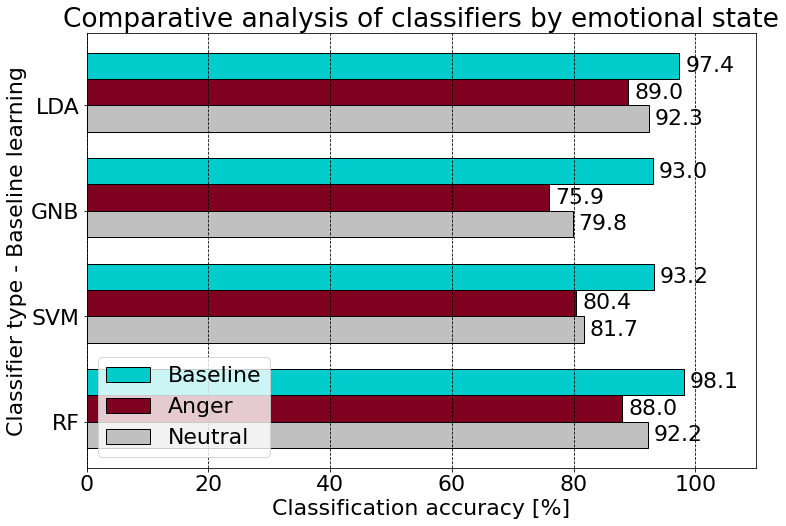

In [39]:
labels = ['RF', 'SVM', 'GNB', 'LDA']
baseline_acc = [float(rforest_scores[0]) * 100, float(svm_scores[0]) * 100, float(gnb_scores[0]) * 100, float(lda_scores[0]) * 100]
anger_acc = [float(rforest_scores[1]) * 100, float(svm_scores[1]) * 100, float(gnb_scores[1]) * 100, float(lda_scores[1]) * 100]
neutral_acc = [float(rforest_scores[2]) * 100, float(svm_scores[2]) * 100, float(gnb_scores[2]) * 100, float(lda_scores[2]) * 100]

plt.rcParams.update({'font.size': 22})

n = 4
r = np.arange(n)
height = 0.25

plt.figure(figsize=(12, 8))
plt.barh(r + 2 * height, baseline_acc, color='#00CCCC',
         height=height, edgecolor='black',
         label='Baseline')
plt.barh(r + height, anger_acc, color='#800020',
         height=height, edgecolor='black',
         label='Anger')
plt.barh(r, neutral_acc, color='#C0C0C0',
         height=height, edgecolor='black',
         label='Neutral')

plt.grid(axis='x', linestyle='--', color='black')
plt.yticks(r + height/2, labels)
plt.legend(loc='lower left')
plt.xlabel('Classification accuracy [%]')
plt.ylabel('Classifier type - Baseline learning')
plt.title('Comparative analysis of classifiers by emotional state')
plt.xlim((0, 110))

for i, v in enumerate(neutral_acc):
    plt.text(v + 1, i, f'{v:.1f}', color='black', va='center')

for i, v in enumerate(anger_acc):
    plt.text(v + 1, i + height, f'{v:.1f}', color='black', va='center')

for i, v in enumerate(baseline_acc):
    plt.text(v + 1, i + 2 * height, f'{v:.1f}', color='black', va='center')

plt.show()


In [40]:
print(np.round(svm_precision_recall_fscore*100,2).T)

[[90.27 82.48 86.41]
 [92.63 80.41 81.67]
 [90.94 79.38 82.21]]
